# Install detectron2

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'detectron2' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

We first download our COCO dataset:

In [4]:
# !gdown --id 13tvUZVZKmV3WOq3K6cLMxzpCUiNEfaUJ
# !unzip /content/datka.zip > /dev/null

import gdown

gdown.download(
   f"https://drive.google.com/uc?export=download&confirm=pbef&id=13tvUZVZKmV3WOq3K6cLMxzpCUiNEfaUJ",
   None
)
!unzip /content/datka.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=13tvUZVZKmV3WOq3K6cLMxzpCUiNEfaUJ
To: /content/datka.zip
100%|██████████| 37.3M/37.3M [00:00<00:00, 163MB/s]


replace data/graph20221220_1831132.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import glob

def get_dict_list(dir_name: str):
  file_list = glob.glob(os.path.join(dir_name, '*.json'))
  dict_list = []
  for file in file_list:
    with open(file) as f:
      json_file = json.load(f)
      file_name = json_file['file_name'].split("\\")[-1]
      json_file['file_name'] = os.path.join(dir_name, file_name)
      dict_list.append(json_file)
  return dict_list

In [5]:
# train
dir_name = "/content/data"
DatasetCatalog.register("graph_train", lambda dir_name=dir_name: get_dict_list(dir_name))
# val
dir_name = "/content/data_val"
DatasetCatalog.register("graph_val", lambda dir_name=dir_name: get_dict_list(dir_name))

[{'bbox': [2, 68, 66, 5], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [140, 68, 202, 6], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [306, 68, 368, 7], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [476, 73, 546, 2], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [645, 70, 710, 5], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [781, 70, 847, 3], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [28, 63, 165, 23], 'bbox_mode': 0, 'category_id': 2}, {'bbox': [165, 63, 331, 23], 'bbox_mode': 0, 'category_id': 2}, {'bbox': [331, 63, 505, 23], 'bbox_mode': 0, 'category_id': 2}, {'bbox': [505, 63, 671, 23], 'bbox_mode': 0, 'category_id': 2}, {'bbox': [671, 63, 808, 23], 'bbox_mode': 0, 'category_id': 2}, {'bbox': [808, 23, 671, 63], 'bbox_mode': 0, 'category_id': 2}]


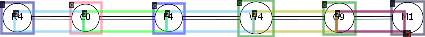

In [6]:
dataset_dicts = get_dict_list("data_val")
for d in random.sample(dataset_dicts, 1):
  print(d["annotations"])
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN R-CNN model on the dataset.


In [7]:
# делаем конфиг
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

In [8]:
# чутка его меняем под наши нужды
cfg.DATASETS.TRAIN = ("graph_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

In [18]:
# Let training initialize from model zoo
# Если дообучаем, то в cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "....pth")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# если колаб не выделил GPU
#cfg.MODEL.DEVICE = "cpu"
#########################################################
cfg.SOLVER.IMS_PER_BATCH = 2 # This is the real "batch size" commonly known to deep learn
cfg.SOLVER.BASE_LR = 0.00025 # pick a good LR
cfg.SOLVER.MAX_ITER = 2000 # 300 iterations seems good enough for this toy dataset; you
cfg.SOLVER.STEPS = [] # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # The "RoIHead batch size". 128 is faster
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # edge type 1, edge type 2 and node

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [19]:
from detectron2.engine import DefaultTrainer

# обучение
trainer = DefaultTrainer(cfg)

[12/24 21:39:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [20]:
trainer.resume_or_load(resume=False)

[12/24 21:39:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [21]:
trainer.train()

[12/24 21:39:57 d2.engine.train_loop]: Starting training from iteration 0
[12/24 21:40:03 d2.utils.events]:  eta: 0:07:04  iter: 19  total_loss: 3.625  loss_cls: 1.459  loss_box_reg: 0.8843  loss_rpn_cls: 1.156  loss_rpn_loc: 0.1132  time: 0.2480  data_time: 0.0125  lr: 4.9953e-06  max_mem: 2889M
[12/24 21:40:07 d2.utils.events]:  eta: 0:06:23  iter: 39  total_loss: 2.746  loss_cls: 1.32  loss_box_reg: 0.9243  loss_rpn_cls: 0.4063  loss_rpn_loc: 0.1054  time: 0.2356  data_time: 0.0066  lr: 9.9902e-06  max_mem: 2889M
[12/24 21:40:11 d2.utils.events]:  eta: 0:06:18  iter: 59  total_loss: 2.229  loss_cls: 1.134  loss_box_reg: 0.9431  loss_rpn_cls: 0.07449  loss_rpn_loc: 0.08013  time: 0.2273  data_time: 0.0063  lr: 1.4985e-05  max_mem: 2889M
[12/24 21:40:16 d2.utils.events]:  eta: 0:06:16  iter: 79  total_loss: 1.97  loss_cls: 0.9082  loss_box_reg: 0.9016  loss_rpn_cls: 0.02813  loss_rpn_loc: 0.07361  time: 0.2282  data_time: 0.0087  lr: 1.998e-05  max_mem: 2889M
[12/24 21:40:21 d2.utils.

Save final model (file with weights) to google drive.

In [23]:
from google.colab import drive
drive.mount('/content/drive')
!cp output/ /content/drive/MyDrive -r

In [26]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # path to the model w
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.45 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/24 21:50:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


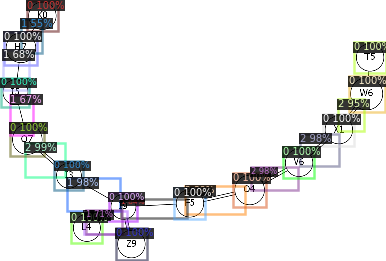

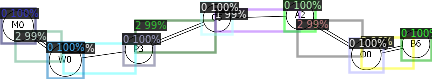

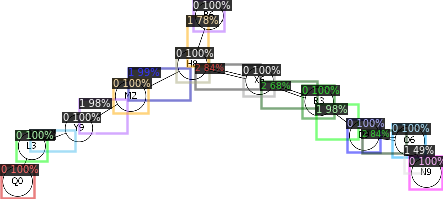

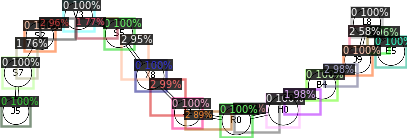

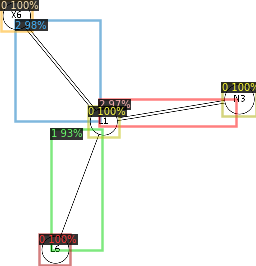

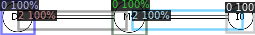

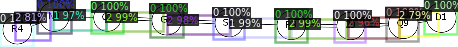

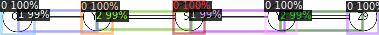

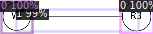

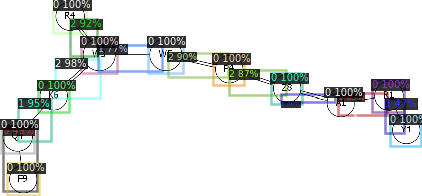

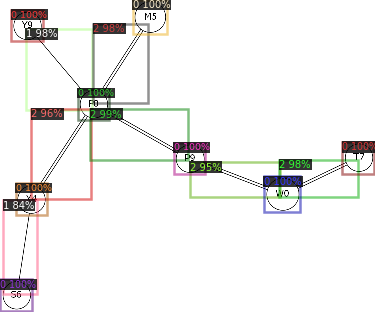

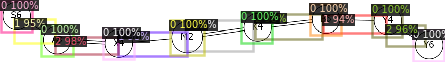

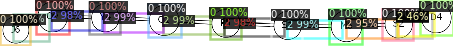

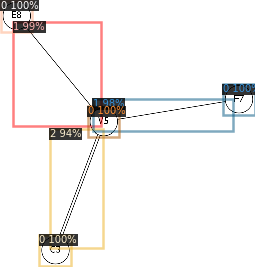

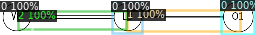

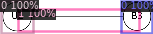

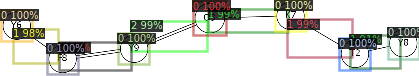

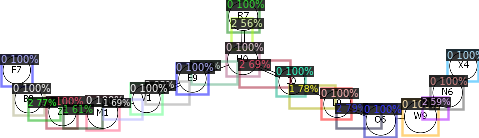

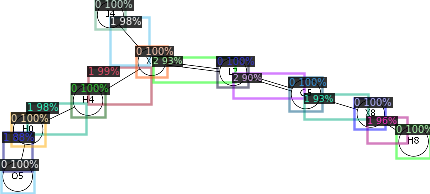

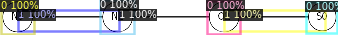

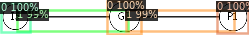

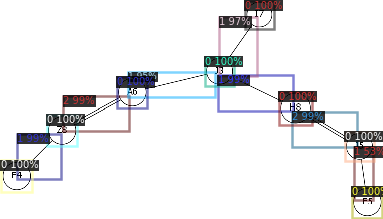

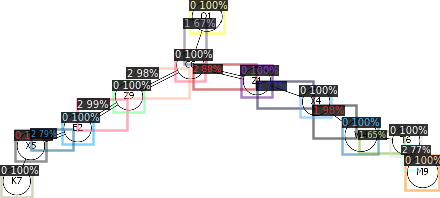

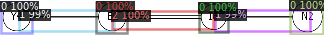

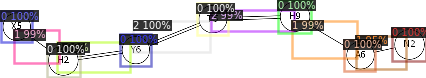

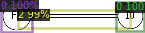

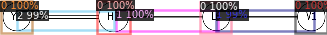

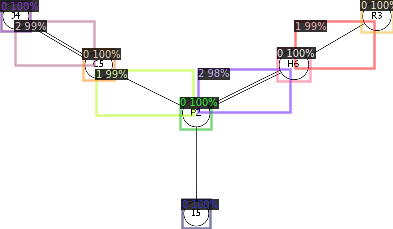

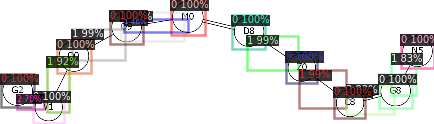

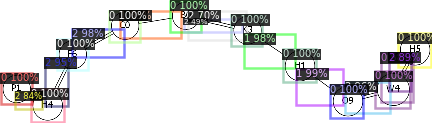

In [28]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dict_list("/content/data_val")
for d in random.sample(dataset_dicts, 30):
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],scale=0.5)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])